# Analysis of Server Logs
This notebook analyzes server logs to identify anomalies, predict failures, enhance security, and optimize performance.

## Step 1: Understanding the Problem

**Log Classification**:
Log classification involves categorizing log entries into predefined categories, such as errors, warnings, informational messages, etc. This helps in quickly identifying and addressing issues.

**BERT (Bidirectional Encoder Representations from Transformers)**:
BERT is a transformer-based model designed for natural language understanding tasks. It can be fine-tuned for specific tasks, such as text classification, by training it on domain-specific data.

### Objective

Fine-tune a pre-trained BERT model to classify Linux logs into meaningful categories.

## Step 2: Preparing the Environment

In [108]:
# Install necessary libraries
%pip install torch torchvision torchaudio
%pip install transformers datasets evaluate accelerate
%pip install pandas matplotlib scikit-learn seaborn


[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [109]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Step 3: Loading and Exploring the Data

**Loading the Log Data**:
We will define a function to load the log data from a file.

In [110]:
# Load and preprocess log data
def load_logs(file_path):
    with open(file_path, "r") as file:
        logs = file.readlines()
    return logs


# Load the log file
log_file_path = "messages"
logs = load_logs(log_file_path)

# Display a few lines from the log file
logs[:10]

['Jun 27 05:11:51 web01 chronyd[733]: Forward time jump detected!\n',
 'Jun 27 05:11:51 web01 systemd[1]: Started Insights Client.\n',
 'Jun 27 05:11:51 web01 systemd[1]: Starting system activity accounting tool...\n',
 'Jun 27 05:11:51 web01 systemd[1]: Starting Generate a daily summary of process accounting...\n',
 'Jun 27 05:11:51 web01 systemd[1]: Starting dnf makecache...\n',
 'Jun 27 05:11:51 web01 systemd[1]: Starting Rotate log files...\n',
 'Jun 27 05:11:51 web01 systemd[1]: sysstat-collect.service: Deactivated successfully.\n',
 'Jun 27 05:11:51 web01 systemd[1]: Finished system activity accounting tool.\n',
 'Jun 27 05:11:51 web01 systemd[1]: sysstat-summary.service: Deactivated successfully.\n',
 'Jun 27 05:11:51 web01 systemd[1]: Finished Generate a daily summary of process accounting.\n']

## Step 4: Preprocessing the Data

**Text Preprocessing**:
Text preprocessing involves cleaning and preparing text data for modeling. This includes tasks like removing unnecessary characters, tokenization, and converting text to lowercase.

In [111]:
# Define the classification labels
labels = {
    "Time and Date": ["chronyd", "timedatectl"],
    "Service/Process Start and Stop": [
        "systemd",
        "Started",
        "Starting",
        "Stopped",
        "Stopping",
    ],
    "Errors and Warnings": ["error", "fail", "warn", "critical"],
    "System Activity": ["system activity", "accounting", "logrotate", "dnf"],
    "Security": ["promtail", "file watcher", "CREATE", "DELETE"],
    "Network Issues": ["network", "connection", "timeout", "unreachable"],
    "System Configuration": ["kernel", "BIOS", "config"],
}

# Include 'Uncategorized' in the labels
labels["Uncategorized"] = []


def preprocess_log(log):
    # Remove timestamps and other unnecessary characters
    log = re.sub(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", "", log)  # Remove timestamps
    log = re.sub(r"[^\w\s]", "", log)  # Remove punctuation
    log = log.lower()  # Convert to lowercase
    return log


# Function to categorize log entries
def categorize_log(log_entry):
    for label, keywords in labels.items():
        if any(keyword in preprocess_log(log_entry) for keyword in keywords):
            return label
    return "Uncategorized"


# Apply categorization to logs
labeled_logs = [(log, categorize_log(log)) for log in logs]

# Convert to DataFrame
df = pd.DataFrame(labeled_logs, columns=["Log", "Category"])

# Display the first few labeled logs
df.head()

,Log,Category
0,Jun 27 05:11:51 web01 chronyd[733]: Forward ti...,Time and Date
1,Jun 27 05:11:51 web01 systemd[1]: Started Insi...,Service/Process Start and Stop
2,Jun 27 05:11:51 web01 systemd[1]: Starting sys...,Service/Process Start and Stop
3,Jun 27 05:11:51 web01 systemd[1]: Starting Gen...,Service/Process Start and Stop
4,Jun 27 05:11:51 web01 systemd[1]: Starting dnf...,Service/Process Start and Stop


System Configuration              1519
Service/Process Start and Stop    1058
Errors and Warnings                465
Uncategorized                      213
Network Issues                     100
Security                            28
Time and Date                       18
System Activity                     18
Name: Category, dtype: int64


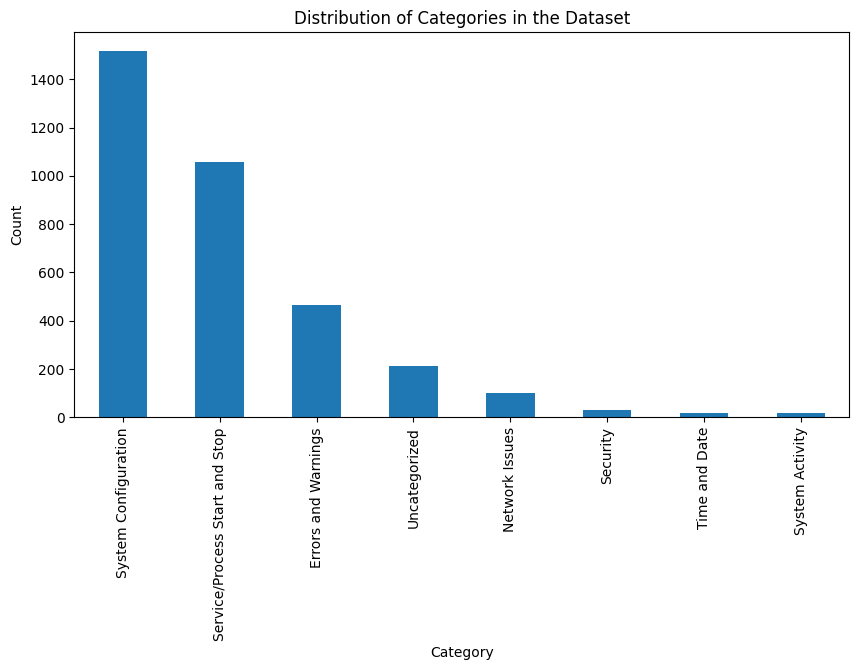

In [112]:
# Assuming 'df' is your DataFrame containing the logs and their categories
category_counts = df["Category"].value_counts()
print(category_counts)

# Plot the distribution
category_counts.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories in the Dataset")
plt.show()

## Step 5: Prepare Data for Modeling

**Data Preparation**:
We will prepare the data for modeling by vectorizing the text data and converting labels to indices.

In [113]:
# Split the data into training and testing sets
X = df["Log"]
y = df["Category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Convert labels to indices
label_to_index = {label: idx for idx, label in enumerate(df["Category"].unique())}
y_train_idx = torch.tensor([label_to_index[label] for label in y_train], dtype=torch.long)
y_test_idx = torch.tensor([label_to_index[label] for label in y_test], dtype=torch.long)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)


## Step 6: Define the Neural Network Model

**Model Definition**:
We will define a simple neural network model for classification using PyTorch.

In [114]:
class LogClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
output_dim = len(label_to_index)
model = LogClassifier(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 7: Train the Model

**Model Training**:
We will train the neural network model on the training data.

In [115]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_idx)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.0878
Epoch [2/10], Loss: 2.0393
Epoch [3/10], Loss: 1.9921
Epoch [4/10], Loss: 1.9440
Epoch [5/10], Loss: 1.8937
Epoch [6/10], Loss: 1.8410
Epoch [7/10], Loss: 1.7857
Epoch [8/10], Loss: 1.7278
Epoch [9/10], Loss: 1.6678
Epoch [10/10], Loss: 1.6063


## Step 8: Evaluate the Model

**Model Evaluation**:
We will evaluate the model's performance on the test set.

In [116]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    original_predicted_categories = [list(label_to_index_combined.keys())[idx] for idx in predicted]
    accuracy = accuracy_score(y_test_idx, predicted)
    precision = precision_score(y_test_idx, predicted, average='weighted')
    recall = recall_score(y_test_idx, predicted, average='weighted')
    f1 = f1_score(y_test_idx, predicted, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(classification_report(y_test_idx, predicted, target_names=label_to_index.keys()))

Accuracy: 0.9561
Precision: 0.9486
Recall: 0.9561
F1 Score: 0.9485
                                precision    recall  f1-score   support

                 Time and Date       1.00      0.60      0.75         5
Service/Process Start and Stop       0.94      0.98      0.96       212
           Errors and Warnings       0.95      1.00      0.98        82
                      Security       0.00      0.00      0.00         6
               System Activity       1.00      0.50      0.67         4
                 Uncategorized       0.95      0.87      0.91        46
          System Configuration       0.97      1.00      0.98       313
                Network Issues       1.00      0.44      0.61        16

                      accuracy                           0.96       684
                     macro avg       0.85      0.67      0.73       684
                  weighted avg       0.95      0.96      0.95       684



/opt/app-root/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/app-root/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/app-root/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/app-root/lib64/python3.9/site-packages/sklearn/metrics/_clas

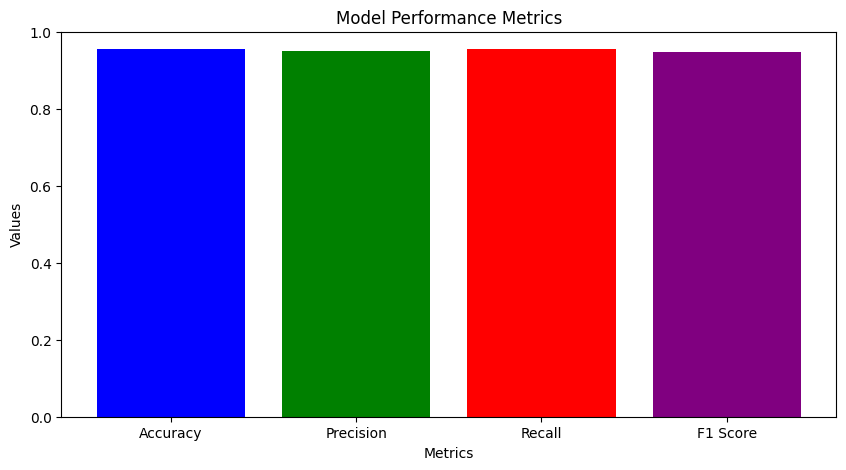

In [117]:
# Plot model metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 5))
plt.bar(names, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.show()

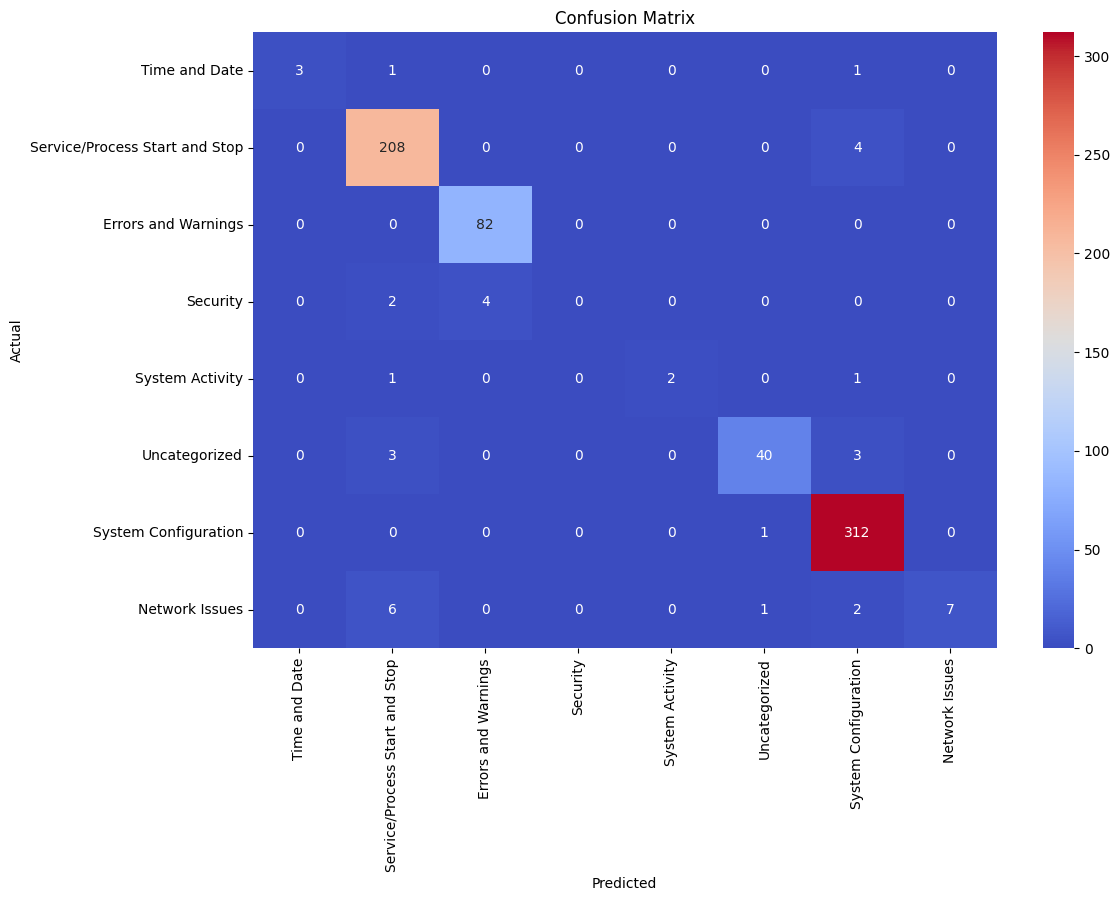

In [118]:
# Plot the confusion matrix
cm = confusion_matrix(y_test_idx, predicted)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Step 12: Save the Trained Model

**Saving the Model**:
We will save the trained model's state dictionary so that it can be loaded and used later.

In [119]:
# Save the trained model's state dictionary
model_save_path = "log_classifier_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to log_classifier_model.pth


## Step 13: Load and Preprocess CVE Logs

**Loading CVE Logs**:
We will load the CVE logs from the provided CSV file and preprocess them similarly to the original logs.

In [120]:
# Load the CVE logs
cve_data_path = "vulnerability_cves--2024-07-01-12-19-52-utc.csv"
cve_data = pd.read_csv(cve_data_path)

# Display the first few rows of the CVE logs
cve_data.head()

,type,id,synopsis,public_date,impact,description,cvss2_score,cvss3_score,cve_status_id,status_id,...,business_risk,business_risk_id,business_risk_text,reporter,known_exploit,first_reported,rule,advisories_list,advisory_available,remediation
0,cve,CVE-2024-5642,CVE-2024-5642,2024-06-27T00:00:00+00:00,Low,A vulnerability was found in Python/CPython th...,NaN,2.7,0,0,...,Not Defined,0,NaN,1,False,2024-07-01T12:03:03.575763+00:00,NaN,[],False,0
1,cve,CVE-2024-37370,CVE-2024-37370,2024-06-27T00:00:00+00:00,Moderate,A vulnerability was found in Kerberos. This fl...,NaN,NaN,0,0,...,Not Defined,0,NaN,1,False,2024-07-01T12:03:03.575763+00:00,NaN,[],False,0
2,cve,CVE-2024-37371,CVE-2024-37371,2024-06-27T00:00:00+00:00,Moderate,A vulnerability was found in Kerberos. This fl...,NaN,NaN,0,0,...,Not Defined,0,NaN,1,False,2024-07-01T12:03:03.575763+00:00,NaN,[],False,0
3,cve,CVE-2024-6104,CVE-2024-6104,2024-06-24T00:00:00+00:00,Moderate,A vulnerability was found in go-retryablehttp....,NaN,6.0,0,0,...,Not Defined,0,NaN,1,False,2024-07-01T12:03:03.575763+00:00,NaN,[],False,0
4,cve,CVE-2024-38384,CVE-2024-38384,2024-06-24T00:00:00+00:00,Moderate,"In the Linux kernel, the following vulnerabili...",NaN,5.5,0,0,...,Not Defined,0,NaN,1,False,2024-07-01T12:03:03.575763+00:00,NaN,[],False,0


## Step 13: Feature Engineering on CVE Data

**Feature Engineering**:
We will create synthetic log messages or extract relevant features from the CVE data to use in our model.


In [121]:
# Create synthetic log messages from the CVE data
# For simplicity, we'll concatenate the 'synopsis', 'description', and 'impact' columns to create a synthetic log message

cve_data['Log'] = cve_data.apply(lambda row: f"{row['synopsis']} {row['description']} Impact: {row['impact']}", axis=1)

# Assign 'Security' category to all CVE logs
cve_data['Category'] = 'Security'

# Display the first few rows after feature engineering
cve_data[['Log', 'Category']].head()

,Log,Category
0,CVE-2024-5642 A vulnerability was found in Pyt...,Security
1,CVE-2024-37370 A vulnerability was found in Ke...,Security
2,CVE-2024-37371 A vulnerability was found in Ke...,Security
3,CVE-2024-6104 A vulnerability was found in go-...,Security
4,"CVE-2024-38384 In the Linux kernel, the follow...",Security


## Step 14: Combine CVE Logs with Existing Logs

**Combining Logs**:
We will combine the synthetic CVE logs with the original logs to create an enriched dataset for fine-tuning the model.

In [122]:
# Convert the original logs DataFrame to match the format of the CVE logs
original_logs_df = df[['Log', 'Category']]

# Combine the DataFrames
combined_logs_df = pd.concat([original_logs_df, cve_data[['Log', 'Category']]], ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_logs_df.head()

,Log,Category
0,Jun 27 05:11:51 web01 chronyd[733]: Forward ti...,Time and Date
1,Jun 27 05:11:51 web01 systemd[1]: Started Insi...,Service/Process Start and Stop
2,Jun 27 05:11:51 web01 systemd[1]: Starting sys...,Service/Process Start and Stop
3,Jun 27 05:11:51 web01 systemd[1]: Starting Gen...,Service/Process Start and Stop
4,Jun 27 05:11:51 web01 systemd[1]: Starting dnf...,Service/Process Start and Stop


## Step 15: Prepare Combined Data for Modeling

**Data Preparation**:
We will prepare the combined data for modeling by vectorizing the text data and converting labels to indices.

In [155]:
# Split the data into training and testing sets
X_combined = combined_logs_df["Log"]
y_combined = combined_logs_df["Category"]
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer_combined = CountVectorizer()
X_train_combined_vec = vectorizer_combined.fit_transform(X_train_combined).toarray()
X_test_combined_vec = vectorizer_combined.transform(X_test_combined).toarray()

# Convert labels to indices
label_to_index_combined = {label: idx for idx, label in enumerate(combined_logs_df["Category"].unique())}
y_train_combined_idx = torch.tensor([label_to_index_combined[label] for label in y_train_combined], dtype=torch.long)
y_test_combined_idx = torch.tensor([label_to_index_combined[label] for label in y_test_combined], dtype=torch.long)

# Convert to PyTorch tensors
X_train_combined_tensor = torch.tensor(X_train_combined_vec, dtype=torch.float32)
X_test_combined_tensor = torch.tensor(X_test_combined_vec, dtype=torch.float32)

# Check the dimensions of the input tensors
input_dim_combined = X_train_combined_tensor.shape[1]
print(f"Input dimension of the combined dataset: {input_dim_combined}")

Input dimension of the combined dataset: 19995


## Step 16: Fine-Tune the Neural Network Model

**Model Fine-Tuning**:
We will fine-tune the neural network model using the combined dataset.

In [156]:
class LogClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model with the correct input dimension
output_dim_combined = len(label_to_index_combined)
model_combined = LogClassifier(input_dim_combined, output_dim_combined)

criterion_combined = nn.CrossEntropyLoss()
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)

## Step 17: Fine-Tune the Neural Network Model

**Model Fine-Tuning**:
We will fine-tune the neural network model using the combined dataset.

In [157]:
# Fine-tune the model
num_epochs_fine_tune = 10
loss_values = []

for epoch in range(num_epochs_fine_tune):
    model_combined.train()
    optimizer_combined.zero_grad()
    outputs = model_combined(X_train_combined_tensor)
    loss = criterion_combined(outputs, y_train_combined_idx)
    loss.backward()
    optimizer_combined.step()
    
    loss_values.append(loss.item())
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_fine_tune}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 2.1079
Epoch [2/10], Loss: 2.0073
Epoch [3/10], Loss: 1.9158
Epoch [4/10], Loss: 1.8288
Epoch [5/10], Loss: 1.7483
Epoch [6/10], Loss: 1.6724
Epoch [7/10], Loss: 1.5996
Epoch [8/10], Loss: 1.5290
Epoch [9/10], Loss: 1.4604
Epoch [10/10], Loss: 1.3940


## Step 18: Evaluate the Fine-Tuned Model

**Model Evaluation**:
We will evaluate the fine-tuned model's performance on the test set.

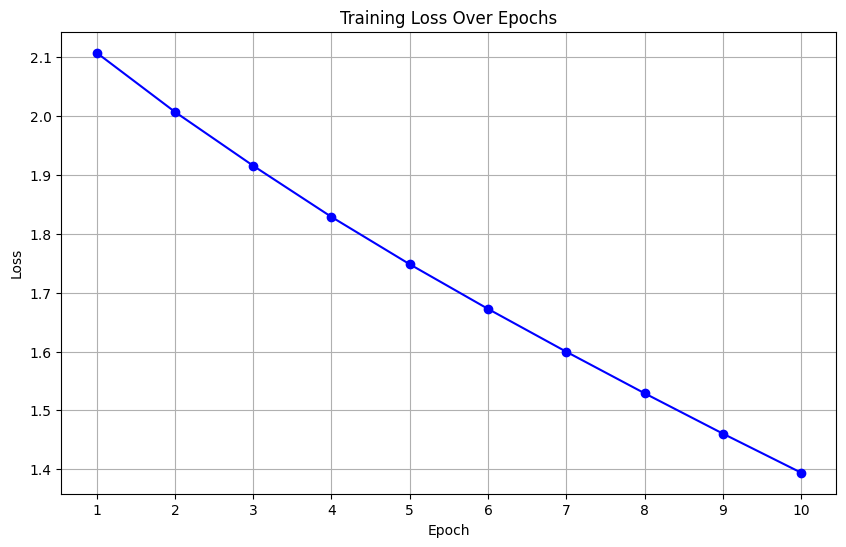

In [158]:
# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_fine_tune + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.xticks(range(1, num_epochs_fine_tune + 1))
plt.grid(True)
plt.show()

In [159]:
model_combined.eval()
with torch.no_grad():
    outputs = model_combined(X_test_combined_tensor)
    _, predicted = torch.max(outputs, 1)
    fine_tuned_predicted_categories = [list(label_to_index_combined.keys())[idx] for idx in predicted]
    accuracy = accuracy_score(y_test_combined_idx, predicted)
    precision = precision_score(y_test_combined_idx, predicted, average='weighted')
    recall = recall_score(y_test_combined_idx, predicted, average='weighted')
    f1 = f1_score(y_test_combined_idx, predicted, average='weighted')
    
    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Print classification report
    class_report = classification_report(y_test_combined_idx, predicted, target_names=label_to_index_combined.keys())
    print("Classification Report:\n", class_report)


Accuracy: 0.9774
Precision: 0.9781
Recall: 0.9774
F1 Score: 0.9763
Classification Report:
                                 precision    recall  f1-score   support

                 Time and Date       1.00      0.50      0.67         4
Service/Process Start and Stop       0.95      1.00      0.97       205
           Errors and Warnings       1.00      0.93      0.96        98
                      Security       0.97      1.00      0.98       240
               System Activity       1.00      0.50      0.67         2
                 Uncategorized       0.97      0.84      0.90        44
          System Configuration       1.00      1.00      1.00       319
                Network Issues       1.00      0.75      0.86        16

                      accuracy                           0.98       928
                     macro avg       0.99      0.81      0.88       928
                  weighted avg       0.98      0.98      0.98       928



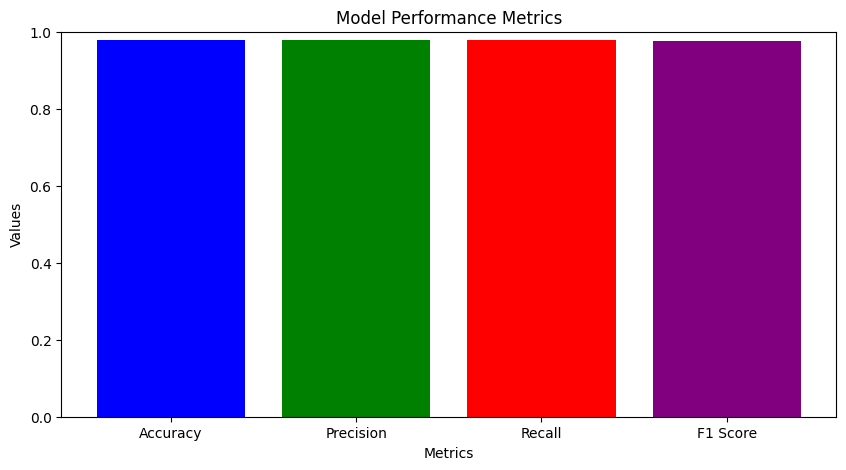

In [160]:
# Plot model metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 5))
plt.bar(names, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.show()

Confusion Matrix:
 [[  2   1   0   1   0   0   0   0]
 [  0 205   0   0   0   0   0   0]
 [  0   1  91   5   0   1   0   0]
 [  0   0   0 240   0   0   0   0]
 [  0   1   0   0   1   0   0   0]
 [  0   4   0   2   0  37   1   0]
 [  0   0   0   0   0   0 319   0]
 [  0   4   0   0   0   0   0  12]]


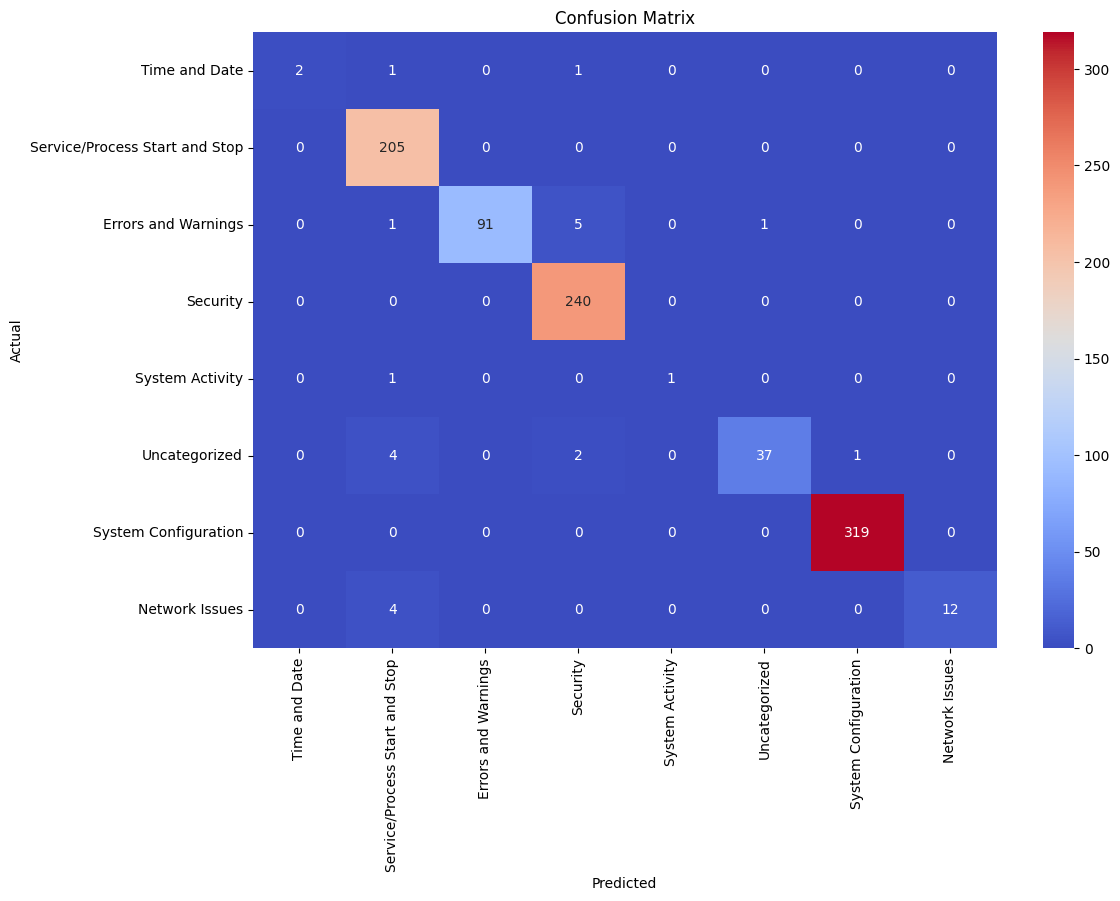

In [161]:
# Print confusion matrix
cm = confusion_matrix(y_test_combined_idx, predicted)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_to_index_combined.keys(), yticklabels=label_to_index_combined.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [168]:
# Save the trained model's state dictionary
model_save_path = "log_classifier_fine_tuned_model.pth"
torch.save(model_combined.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to log_classifier_fine_tuned_model.pth


## Step 18: Predict Categories for New Log Data

**Using the Model**:
We will use the fine-tuned model to predict the categories of new log messages.

In [169]:
# Load the log file
new_log_file_path = "messages-20240612"
new_logs = load_logs(new_log_file_path)

# Display a few lines from the log file
new_logs[:10]

# Preprocess new logs
new_logs_preprocessed = [preprocess_log(log) for log in new_logs]

# Vectorize the new log data
new_logs_vec = vectorizer_combined.transform(new_logs_preprocessed).toarray()
new_logs_tensor = torch.tensor(new_logs_vec, dtype=torch.float32)

# Predict categories using the fine-tuned model
model_combined.eval()
with torch.no_grad():
    outputs = model_combined(new_logs_tensor)
    _, predicted_categories_idx = torch.max(outputs, 1)
    predicted_categories = [list(label_to_index_combined.keys())[idx] for idx in predicted_categories_idx]

## Step 19: Incident Frequency and Severity Tracking

**Incident Tracking**:
We will track the frequency and severity of incidents categorized by the model for the new log data.


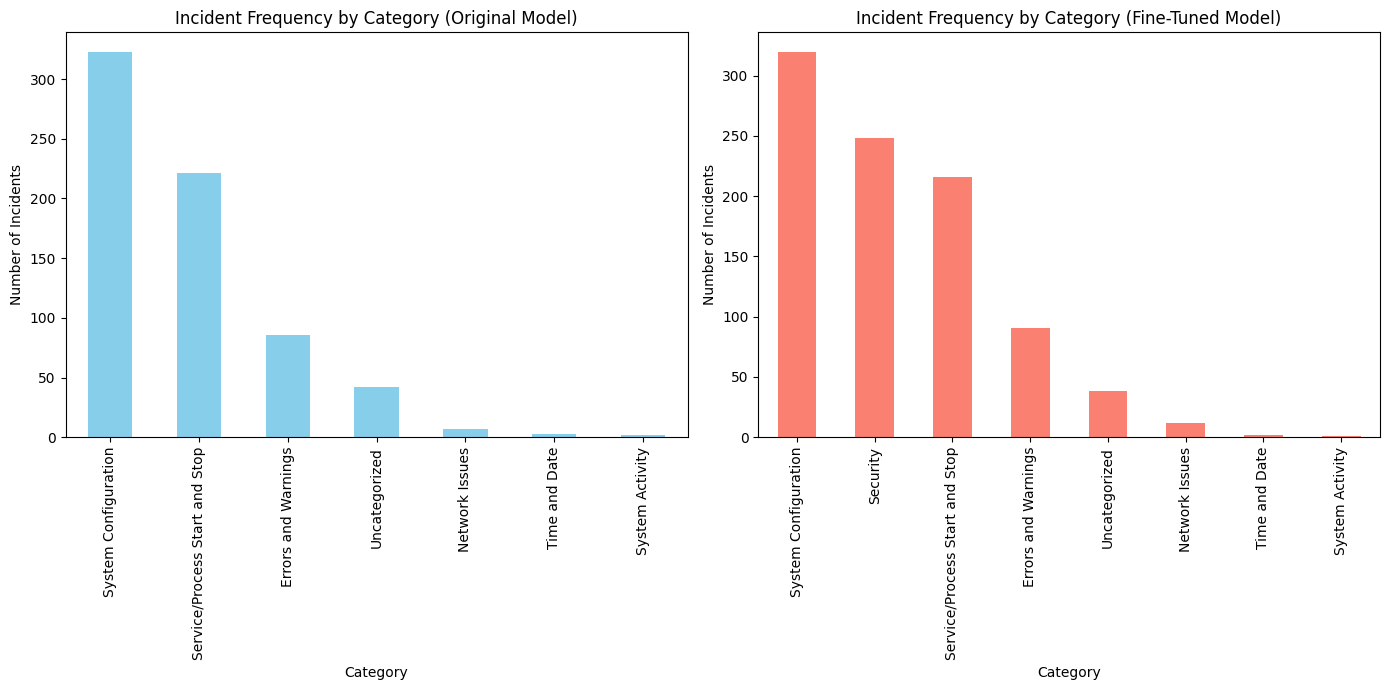

In [170]:
# Count the frequency of predicted categories
original_incident_counts = pd.Series(original_predicted_categories).value_counts()
fine_tuned_incident_counts = pd.Series(fine_tuned_predicted_categories).value_counts()

# Plot the incident frequency comparison
plt.figure(figsize=(14, 7))

# Original model
plt.subplot(1, 2, 1)
original_incident_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Incidents')
plt.title('Incident Frequency by Category (Original Model)')

# Fine-tuned model
plt.subplot(1, 2, 2)
fine_tuned_incident_counts.plot(kind='bar', color='salmon')
plt.xlabel('Category')
plt.ylabel('Number of Incidents')
plt.title('Incident Frequency by Category (Fine-Tuned Model)')

plt.tight_layout()
plt.show()

## Step 24: Predict the Next Token in a Log Message

**Next Token Prediction**:
We will demonstrate the ability to predict the next token in a log message using a simple n-gram model.

In [176]:
from collections import defaultdict, Counter
import random

# Build a simple n-gram model from the log data
def build_ngram_model(logs, n=2):
    ngrams = defaultdict(Counter)
    for log in logs:
        tokens = log.split()
        for i in range(len(tokens) - n):
            gram = tuple(tokens[i:i+n])
            next_token = tokens[i+n]
            ngrams[gram][next_token] += 1
    return ngrams

# Function to predict the next tokens using the n-gram model
def predict_next_tokens(ngrams, current_tokens, n=2, num_tokens=3):
    tokens = current_tokens[:]
    for _ in range(num_tokens):
        gram = tuple(tokens[-(n-1):])
        if gram in ngrams:
            next_token = ngrams[gram].most_common(1)[0][0]
        else:
            next_token = random.choice(list(ngrams.keys()))[-1]
        tokens.append(next_token)
    return tokens[-num_tokens:]

# Build the n-gram model using the combined logs
combined_logs = combined_logs_df['Log'].apply(preprocess_log).tolist()
ngrams = build_ngram_model(combined_logs, n=2)

In [177]:
# Generate 20 incomplete log entries
incomplete_logs = [
    "Network connection",
    "Systemd service failed",
    "Unauthorized access",
    "Disk usage",
    "Security vulnerability",
    "Kernel panic occurred at",
    "Memory usage is",
    "User login failed due to",
    "File system corruption detected on",
    "High CPU usage on",
    "Service restarted due to",
    "Database connection lost during",
    "Configuration file missing",
    "Backup process started at",
    "Service stopped unexpectedly due to",
    "Firewall rule updated for",
    "Kernel module loaded for",
    "Log rotation completed for",
    "Network interface eth0",
    "System reboot initiated by"
]

# Predict and print the next three tokens for each incomplete log entry
for log in incomplete_logs:
    tokens = log.split()
    next_tokens = predict_next_tokens(ngrams, tokens, n=2, num_tokens=1)
    predicted_sequence = log + " " + " ".join(next_tokens)
    print(f"Original log snippet: {log}")
    print(f"Predicted next tokens: {' '.join(next_tokens)}")
    print(f"Predicted sequence: {predicted_sequence}\n")

Original log snippet: Network connection
Predicted next tokens: __pfx_bnxt_re_mod_init0x100x10
Predicted sequence: Network connection __pfx_bnxt_re_mod_init0x100x10

Original log snippet: Systemd service failed
Predicted next tokens: copy
Predicted sequence: Systemd service failed copy

Original log snippet: Unauthorized access
Predicted next tokens: related
Predicted sequence: Unauthorized access related

Original log snippet: Disk usage
Predicted next tokens: lookup
Predicted sequence: Disk usage lookup

Original log snippet: Security vulnerability
Predicted next tokens: irq_int_handler0x190x30
Predicted sequence: Security vulnerability irq_int_handler0x190x30

Original log snippet: Kernel panic occurred at
Predicted next tokens: handling
Predicted sequence: Kernel panic occurred at handling

Original log snippet: Memory usage is
Predicted next tokens: callerclientgo419
Predicted sequence: Memory usage is callerclientgo419

Original log snippet: User login failed due to
Predicted nex